<a href="https://colab.research.google.com/github/AbrarKarim01/Accurate_Brain_Tumor_Detection-using-DCNN/blob/main/Accurate_Brain_Tumor_Detection_using_DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import cv2
import random
import keras
import keras.layers

random.seed(100)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn import metrics

from tensorflow.keras.applications import VGG16
from keras.applications import InceptionResNetV2, EfficientNetB0

In [ ]:
## dense layer of the figshare
dense_layers_figshare = keras.Sequential([
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax'),
])

## Replacement of the original dense layer
FC_layers_figshare = keras.Sequential([
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dense(3, activation='softmax')
])

## Dense layer for the harvard dataset
dense_layers_harvard = keras.Sequential([
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax'),
])

## Regularized dense layer of harvard
dense_layers_harvard_regularized = keras.Sequential([
    keras.layers.Dense(1024,activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2),
])

## Original CNN layer
CNN_layers = keras.Sequential([

    keras.layers.Conv2D(64, (22, 22), strides=2),
    keras.layers.MaxPool2D((4, 4)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128,(11,11),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256,(7,7),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512,(3,3),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Activation("relu")
])

## Regularized 01 CNN layer
CNN_layers_regularized1 = keras.Sequential([
    keras.layers.Conv2D(64, (22, 22), strides=2),
    keras.layers.MaxPool2D((4, 4)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128,(11,11),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256,(7,7),strides=2,padding="same", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512,(3,3),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Activation("relu")
])

## Regularized 02 CNN layer
CNN_layers_regularized2 = keras.Sequential([
    keras.layers.Conv2D(64, (22, 22), strides=2),
    keras.layers.MaxPool2D((4, 4)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128,(11,11),strides=2,padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256,(7,7),strides=2,padding="same", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512,(3,3),strides=2,padding="same", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Activation("relu")
])

## CNN with Dense (have some problem)
def construct_CNN(base_model, backend_model,  input_shape=None, trainable=False):
  model = keras.Sequential()

  if input_shape is not None:
    model.add(keras.layers.Input(shape=input_shape,name="image"),)

    base_model.trainable = trainable

    for layer in base_model.layers:
      model.add(layer)
  else:
    model = keras.Sequential([base_model])

  for layer in backend_model.layers:
    model.add(layer)


  return model

## CNN with the original dense layer
def construct_CNN_model(baseModel, num_classes=3):
    baseModel.trainable = False
    x = baseModel.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024,activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512,activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x=  keras.layers.Dropout(.2)(x)
    pred = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs = baseModel.input,outputs=pred)
    return model

## CNN with the replaced dense layer
def construct_CNN_FC_model(baseModel):
  baseModel.trainable = False
  x = baseModel.output
  # x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  predictions = keras.layers.Dense(3, activation='softmax')(x)
  model = keras.Model(inputs = baseModel.input,outputs=predictions)
  return model

In [ ]:
total_image=3064

def load_images(data_images, image_size):
  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  size = 4 * total_image // 5
  for i in range(size):
    train_image = data_images[i]['cjdata']["image"]
    if train_image.shape == (512, 512):
      img = np.expand_dims(train_image, axis=0).reshape((512, 512, 1))
      if image_size[0] != 512:
        img = tf.image.resize(img, [image_size[0], image_size[1]])
        if image_size[2] == 3:
          img = tf.image.grayscale_to_rgb(img)
      train_images.append(img) # Expand the image dimensions from (512, 512) to (1, 512, 512) for compatibility with models
      train_labels.append(data_images[i]['cjdata']["label"][0][0]- 1) # Retrieve the label for the image, subtract 1 to make it zero-based, and add to training labels

  for i in range(size, total_image):
    test_image = data_images[i]['cjdata']["image"]
    if test_image.shape == (512, 512):
      img = np.expand_dims(test_image, axis=0).reshape((512, 512, 1))
      if image_size[0] != 512:
        img = tf.image.resize(img, [image_size[0], image_size[1]])
        if image_size[2] == 3:
          img = tf.image.grayscale_to_rgb(img)

      test_images.append(img)
      test_labels.append(data_images[i]['cjdata']["label"][0][0] - 1)
  return train_images, train_labels, test_images, test_labels


# 1. Prepare the Figshare dataset

## 1.1 Read the image files from the disk

In [ ]:
brain_data = '/content/drive/MyDrive/COMP-5112/Brain_MRI2/BRAIN_DATA'

data_images = []
for i in range(1,total_image+1):
  filename=str(i)+".mat" # Construct the filename for the current image file (e.g., "1.mat", "2.mat", etc.)
  data=h5py.File(os.path.join(brain_data,filename),"r")  # Load the .mat file using h5py in read mode and store the data in a variable
  data_images.append(data)

  if i%100==0:
    print(filename)

random.shuffle(data_images)

100.mat
200.mat
300.mat
400.mat
500.mat
600.mat
700.mat
800.mat
900.mat
1000.mat
1100.mat
1200.mat
1300.mat
1400.mat
1500.mat
1600.mat
1700.mat
1800.mat
1900.mat
2000.mat
2100.mat
2200.mat
2300.mat
2400.mat
2500.mat
2600.mat
2700.mat
2800.mat
2900.mat
3000.mat


## 1.2 Randomly plot 8 images from the dataset

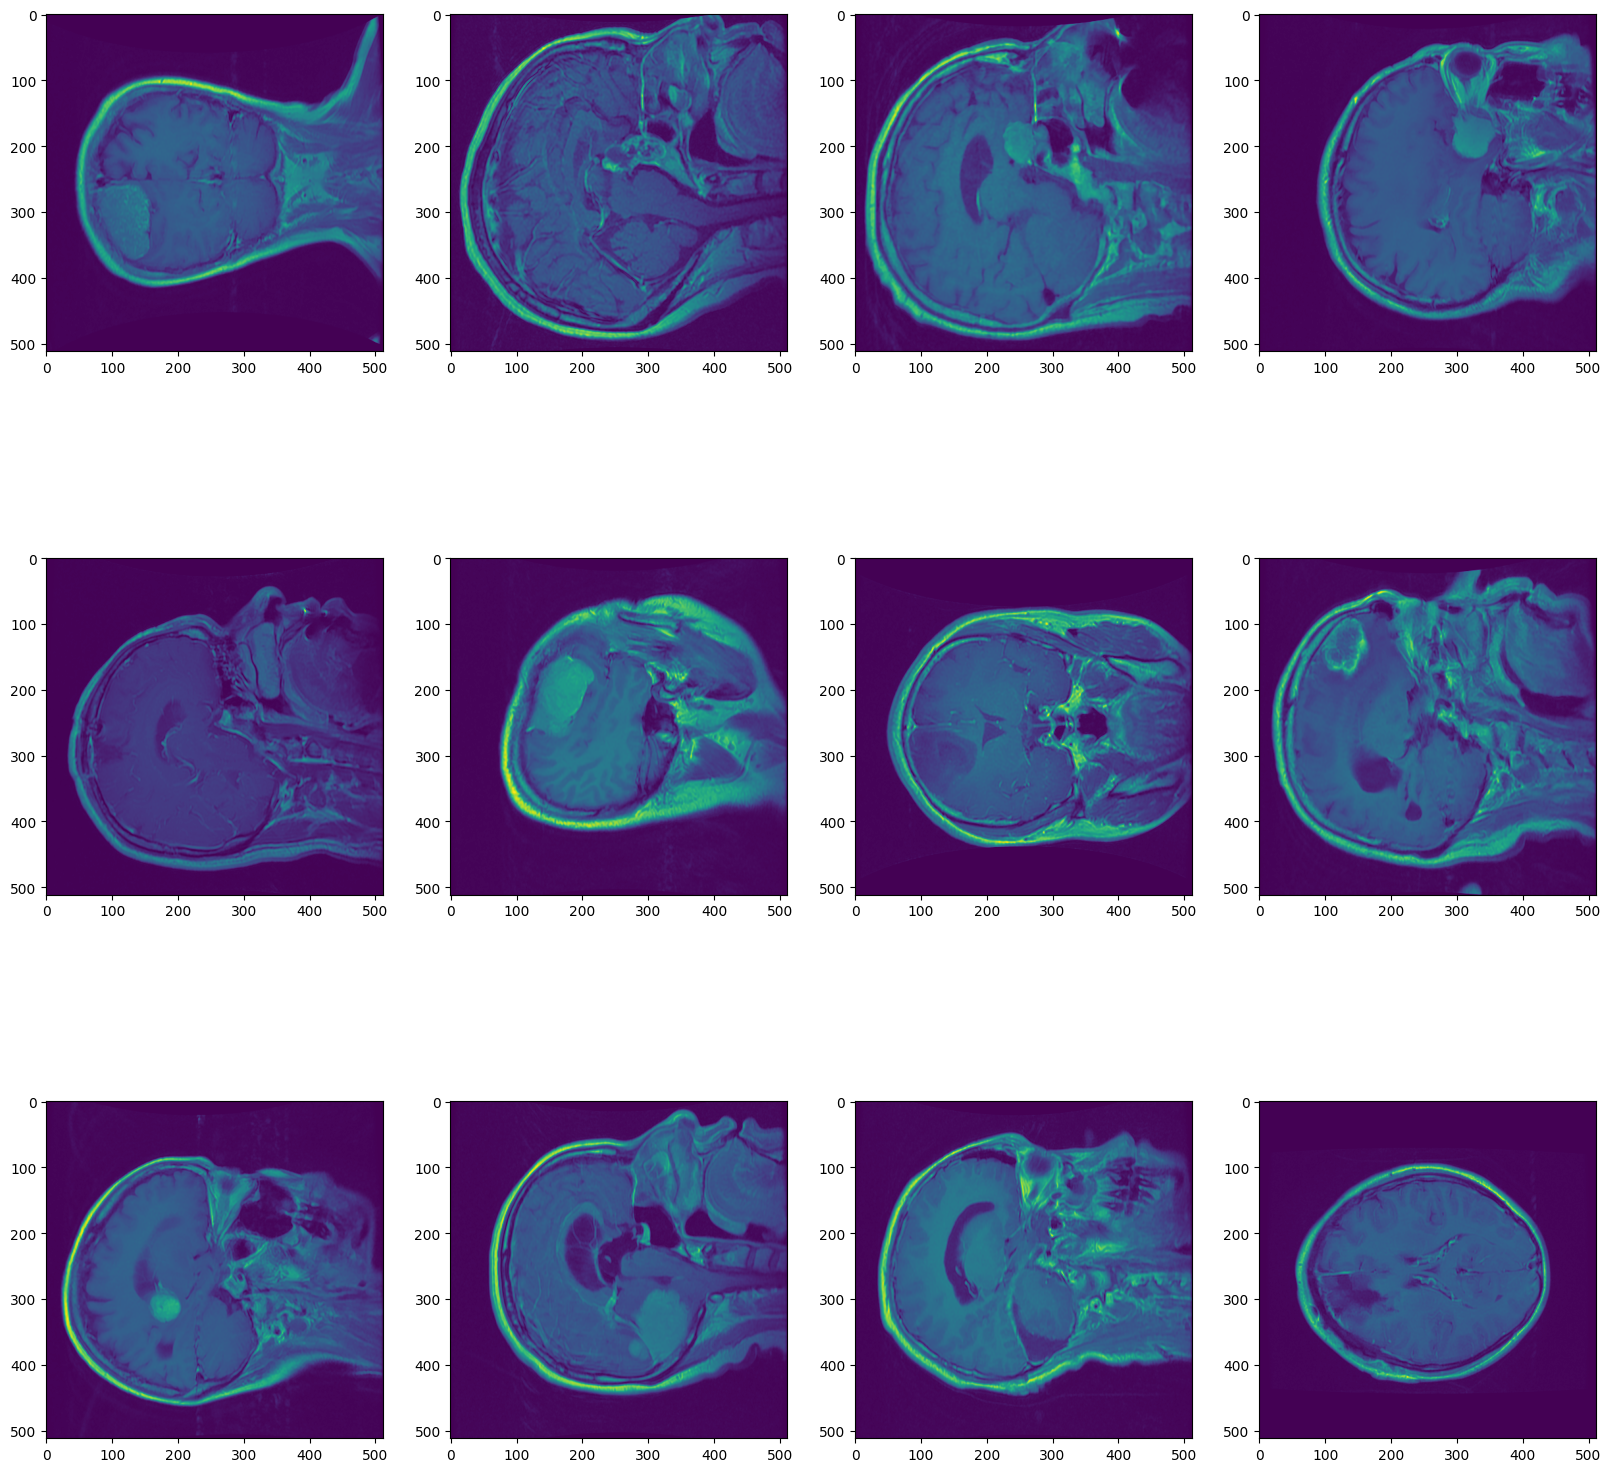

In [ ]:
plt.subplots(3,4,figsize = (20,20)) # Create a 3x4 grid for displaying 12 images, with a figure size of 20x20 inches

for i in range(12):
    img_np = data_images[i]['cjdata']["image"]  # Extract the 'image' data from the current .mat file under the key 'cjdata'

    # Define the subplot location for the current image in a 3x4 grid
    # The subplot index starts from 1 and increments with each iteration
    plt.subplot(3,4,1+i) # Display the image in the specified subplot
    plt.imshow(img_np)
plt.show()

## 1.3 split train dataset and test dataset

In [ ]:
IMAGE_SIZE = [512, 512, 1]

train_images, train_labels, test_images, test_labels = load_images(data_images, IMAGE_SIZE)

## 1.4 Reshape the train_images, test_images, train_labels, test_labels variable

In [ ]:
# Convert the list of training images to a numpy array and reshape it
# Each image will have the shape (512, 512, 1), where 1 represents the single color channel (grayscale)
# '-1' allows numpy to determine the number of images based on the length of the list
train_images = np.array(train_images).reshape(-1, IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2])

# Convert the list of test images to a numpy array and reshape it similarly
# Each image will have the shape (512, 512, 1), matching the format needed for input into a model
test_images = np.array(test_images).reshape(-1, IMAGE_SIZE[0],IMAGE_SIZE[1], IMAGE_SIZE[2])

# Convert the list of training labels to a numpy array for easier manipulation and compatibility with ML libraries
train_labels = np.array(train_labels)

# Convert the list of test labels to a numpy array as well
test_labels = np.array(test_labels)

In [ ]:
train_images.shape

(2440, 512, 512, 1)

In [ ]:
test_images.shape

(609, 512, 512, 1)

# 2. 23 layered on Figshare

## 2.1 construct models

In [ ]:
## change size to IMAGE_SIZE = [512, 512, 1] in 1.3 section

model = construct_CNN(CNN_layers, dense_layers_figshare, (512, 512, 1), True)
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_215 (Conv2D)                  │ (None, 246, 246, 64)        │          31,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_236              │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_216 (Conv2D)                  │ (None, 31, 31, 128)         │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_237              │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_217 (Conv2D)                  │ (None, 8, 8, 256)           │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_238              │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_218 (Conv2D)                  │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_239              │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_206 (Activation)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_227              │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_228              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,001,667 (19.08 MB)

 Trainable params: 4,996,163 (19.06 MB)

 Non-trainable params: 5,504 (21.50 KB)

## 2.2 Fit the model with the training dataset and this process is long

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

r=model.fit(train_images,
          train_labels,
          epochs=80,
          batch_size=32,
          verbose=1,
          validation_data=(test_images,test_labels),
          shuffle=False
          )

IndexError: tuple index out of range

## 2.3 Save the model and history

In [ ]:
# model.save_weights('drive/MyDrive/comp-5011/figshare_model_weights/23-layer-dense.weights.h5')
# hist_csv_file = '/content/drive/MyDrive/comp-5011/figshare_model_history/history_23_layer.csv'

# hist_df = pd.DataFrame(r.history)
# with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)

## 2.4 Load the model and history

In [ ]:
model.load_weights('drive/MyDrive/COMP-5112/figshare_model_weights/23_layer.weights.h5')
history = pd.read_csv('/content/drive/MyDrive/COMP-5112/figshare_model_history/history_23_layer.csv')

hist_df = pd.DataFrame(history)
with open('hist_csv_file', mode='w') as f:
  hist_df.to_csv(f)

##2.5 Plot the model

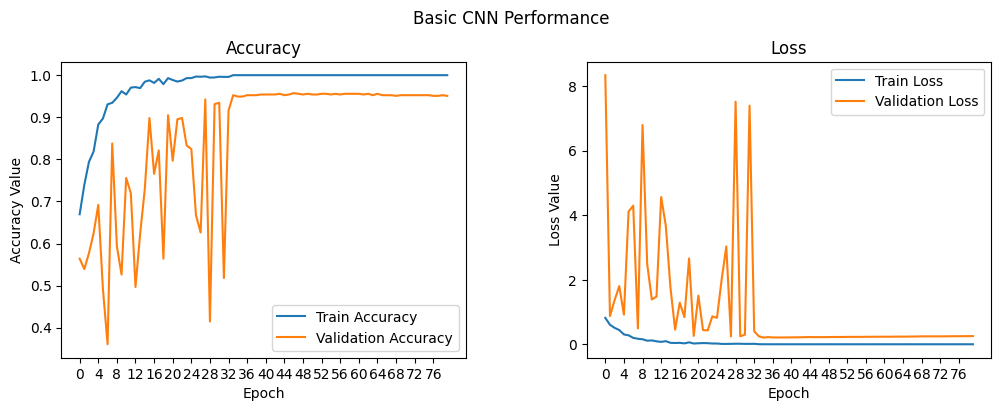

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

# plot the historical accuracy vs the epoch number
epoch_list = list(range(0,80))
ax1.plot(epoch_list, history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


# plot the historical loss value vs the epoch number
ax2.plot(epoch_list, history['loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## 2.6 Predict the labels

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis = 1)

target_names = ['Meningioma', 'Glioma',  'Pituitary']
print(classification_report(test_labels, pred_labels, target_names=target_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step
              precision    recall  f1-score   support

  Meningioma       0.90      0.90      0.90       147
      Glioma       0.95      0.95      0.95       277
   Pituitary       0.99      0.99      0.99       185

    accuracy                           0.95       609
   macro avg       0.95      0.95      0.95       609
weighted avg       0.95      0.95      0.95       609



## 2.7 Evaluation metric: confusion matrix

[Text(0, 0.5, 'Meningioma'), Text(0, 1.5, 'Glioma'), Text(0, 2.5, 'Pituitary')]

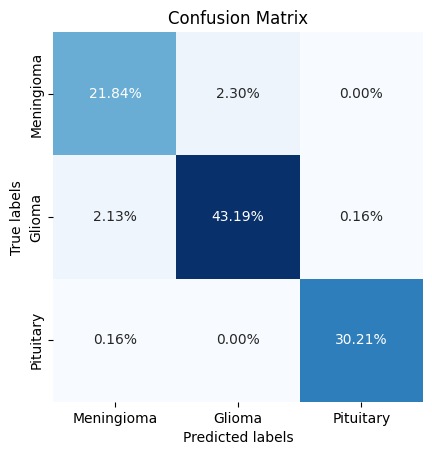

In [ ]:
ax = plt.subplot()
cm = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm / np.sum(cm), square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.2%')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituitary'])
ax.yaxis.set_ticklabels(['Meningioma', 'Glioma',  'Pituitary'])

## 2.8 Evaluation metric: ROC curve

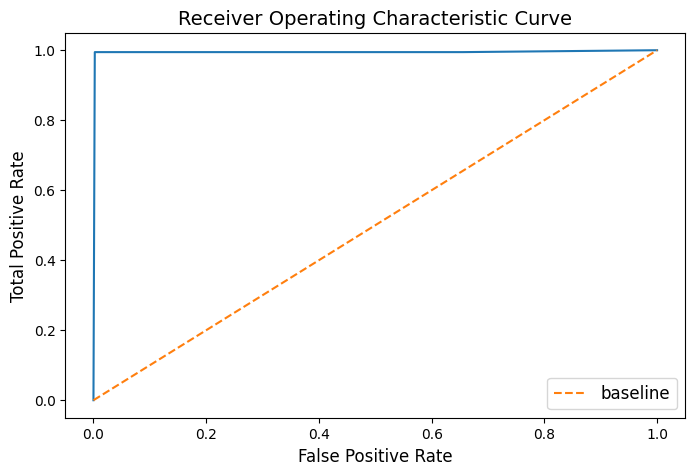

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_labels, pred_labels, pos_label=2)
metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
  # Load the image
  img_path = fn
  img = tf.keras.utils.load_img(img_path, target_size=(512, 512, 3)) # Adjust target_size if needed
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Create a batch

  #Preprocess the image (if necessary, based on how your model was trained)
  #Example preprocessing if your model expects grayscale input:
  img_array = tf.image.rgb_to_grayscale(img_array)
  img_array = img_array.numpy()

  # Make the prediction
  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction)

  # Print the prediction
  print("Prediction:", predicted_class)
  # Map the predicted class index to the class name
  class_names = ['Meningioma', 'Glioma', 'Pituitary']  # Replace with your actual class names
  print("Predicted Class:", class_names[predicted_class])

Saving m.jpg to m (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Prediction: 2
Predicted Class: Pituitary


# 3. Transfer learning with Dense layer backend

## 3.1 Construct the model

In [ ]:
#Initial  BLock of the model
## change size to IMAGE_SIZE = [256, 256, 3] in 1.3 section

#model = construct_CNN_model(InceptionResNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 3)
#model = construct_CNN_model(EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 3)
model = construct_CNN_model(VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 3)

model.summary()

Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,904,067 (60.67 MB)

 Trainable params: 1,185,795 (4.52 MB)

 Non-trainable params: 14,718,272 (56.15 MB)

## 3.2 Fit the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
# steps_per_epoch=train_images.shape[0]//16

r=model.fit(train_images,
          train_labels,
          epochs=80,
          batch_size=32,
          verbose=1,
          validation_data=(test_images,test_labels),
          shuffle=False,
          )

Epoch 1/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 132s 707ms/step - accuracy: 0.4700 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 2/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 3/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 4/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 5/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 6/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 7/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 8/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.4621 - loss: nan - val_accuracy: 0.4548 - val_loss: nan
Epoch 9/80
77/7

KeyboardInterrupt: 

## 3.3 Save the model and history

In [ ]:
#model.save_weights('/content/drive/MyDrive/comp-5011/figshare_model_weights/EfficientB0-dense.weights.h5')
#model.save_weights('drive/MyDrive/COMP-5112/figshare_model_weights/VGG-16.weights.h5')
#model.save_weights('drive/MyDrive/COMP-5112/figshare_model_weights/InceptionRes-dense.weights.h5')

#hist_csv_file = '/content/drive/MyDrive/comp-5011/figshare_model_history/history_efficientb0-dense.csv'
#hist_csv_file = '/content/drive/MyDrive/COMP-5112/figshare_model_history/history_vgg16-dense.csv'
#hist_csv_file = '/content/drive/MyDrive/COMP-5112/figshare_model_history/history_InceptionRes-dense.csv'

KeyboardInterrupt: 

## 3.4 Load the model weight and history

In [ ]:
#model.load_weights('/content/drive/MyDrive/comp-5011/figshare_model_weights/efficientB0-denseweights.h5')
model.load_weights('drive/MyDrive/COMP-5112/figshare_model_weights/VGG16-dense.weights.h5')
#model.load_weights('/content/drive/MyDrive/COMP-5112/figshare_model_weights/InceptionRes-sense.weights.h5')

#history = pd.read_csv('/content/drive/MyDrive/COMP-5112/figshare_model_history/history_InceptionRes-dense.csv')
history = pd.read_csv('drive/MyDrive/COMP-5112/figshare_model_history/history_vgg16-dense.csv')
#history = pd.read_csv('/content/drive/MyDrive/COMP-5112/figshare_model_history/history_efficientb0-dense.csv')

hist_df = pd.DataFrame(history)
with open('hist_csv_file', mode='w') as f:
  hist_df.to_csv(f)

## 3.5 Plotting the history

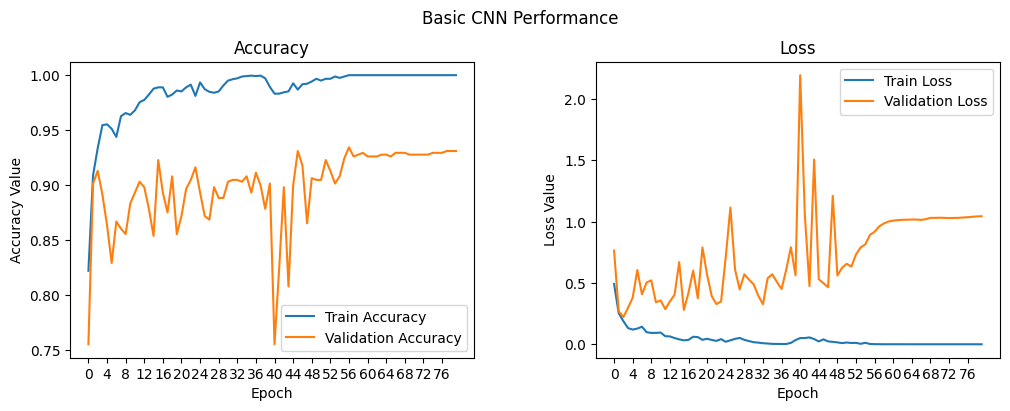

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

# plot the historical accuracy vs the epoch number
epoch_list = list(range(0,80))
ax1.plot(epoch_list,history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


# plot the historical loss value vs the epoch number
ax2.plot(epoch_list, history['loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## 3.6 Prediction of the model

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

target_names = ['Meningioma', 'Glioma',  'Pituitary']
print(classification_report(test_labels, pred_labels, target_names=target_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 540s 27s/step
              precision    recall  f1-score   support

  Meningioma       0.87      0.88      0.87       147
      Glioma       0.96      0.94      0.95       277
   Pituitary       0.93      0.97      0.95       185

    accuracy                           0.93       609
   macro avg       0.92      0.93      0.92       609
weighted avg       0.93      0.93      0.93       609



## 3.7 Confusion matrix

[Text(0, 0.5, 'Meningioma'), Text(0, 1.5, 'Glioma'), Text(0, 2.5, 'Pituitary')]

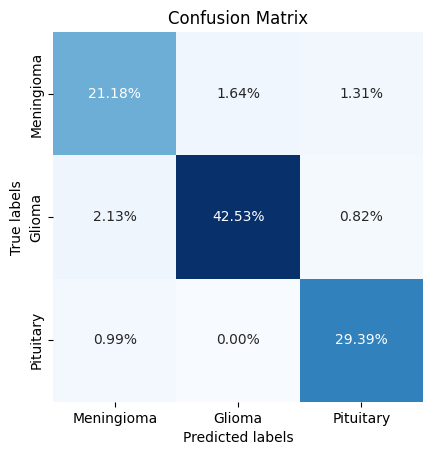

In [ ]:
ax=plt.subplot()
cm=confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm / np.sum(cm), square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.2%')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituitary'])
ax.yaxis.set_ticklabels(['Meningioma', 'Glioma',  'Pituitary'])

## 3.8 Upload and test the model


In [ ]:
from google.colab import files
import numpy as np
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
  # Load the image
  img_path = fn
  img = tf.keras.utils.load_img(img_path, target_size=(256, 256, 3)) # Adjust target_size if needed
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Create a batch

  #Preprocess the image (if necessary, based on how your model was trained)
  #Example preprocessing if your model expects grayscale input:
  #img_array = tf.image.rgb_to_grayscale(img_array)

  # Make the prediction
  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction)

  # Print the prediction
  print("Prediction:", predicted_class)
  # Map the predicted class index to the class name
  class_names = ['Meningioma', 'Glioma', 'Pituitary']  # Replace with your actual class names
  print("Predicted Class:", class_names[predicted_class])

Saving g.jpg to g (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Prediction: 2
Predicted Class: Pituitary


# 4. Shrink 23 layer on Figshare dataset

## 4.1 Construct the model

In [ ]:
model = construct_CNN(CNN_layers, FC_layers_figshare, (512, 512, 1), True)
model.summary()

## 4.2 Fit the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

r=model.fit(train_images,
          train_labels,
          epochs=80,
          batch_size=32,
          verbose=1,
          validation_data=(test_images,test_labels),
          shuffle=False
          )

## 4.3 Save the model history and weight

In [ ]:
# model.save_weights('/content/drive/MyDrive/comp-5011/figshare_model_weights/23-layer-FC.weights.h5')
hist_csv_file = '/content/drive/MyDrive/comp-5011/figshare_model_history/history_23-layer-FC.csv'

# import pandas as pd
# hist_df = pd.DataFrame(r.history)
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

## 4.4 Load the model and the history

In [ ]:
model.load_weights('/content/drive/MyDrive/comp-5011/figshare_model_weights/23-layer-FC.weights.h5')
history = pd.read_csv('/content/drive/MyDrive/comp-5011/figshare_model_history/history_23-layer-FC.csv')

## 4.5 Plotting the model

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

# plot the historical accuracy vs the epoch number
epoch_list = list(range(0,80))
ax1.plot(epoch_list, history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


# plot the historical loss value vs the epoch number
ax2.plot(epoch_list, history['loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## 4.6 Prediction of the model

In [ ]:
pred=model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

target_names = ['Meningioma', 'Glioma',  'Pituitary']
print(classification_report(test_labels, pred_labels, target_names=target_names))

## 4.7 Confusion matrix

In [ ]:
ax=plt.subplot()
cm=confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm / np.sum(cm), square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.2%')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituitary'])
ax.yaxis.set_ticklabels(['Meningioma', 'Glioma',  'Pituitary'])

## 4.8 Roc Curve

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, pred_labels, pos_label=2)
metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

# 5. 23 layered on harvard

## 5.1 Construct the model

In [ ]:
#Initial  BLock of the model
## IMAGE_SIZE = [512, 512, 1]
model = construct_CNN(CNN_layers_regularized2, dense_layers_harvard_regularized, (512, 512, 1), True)

# model = construct_CNN_model(InceptionResNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 2)
# model = construct_CNN_model(EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 2)
# model = construct_CNN_model(VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights="imagenet", include_top=False), 2)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 246, 246, 64)        │          31,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 31, 31, 128)         │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,001,410 (19.08 MB)

 Trainable params: 4,995,906 (19.06 MB)

 Non-trainable params: 5,504 (21.50 KB)

## 5.2 Read the image files and apply data augmentation while reading

In [ ]:
brain_data2 = '/content/drive/MyDrive/comp-5011/Harvard Medical Dataset2'

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2)

train_generator=train_datagen.flow_from_directory(brain_data2, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), color_mode='grayscale' if IMAGE_SIZE[2] == 1 else "rgb", shuffle=True, subset='training', batch_size=10, class_mode='categorical', seed=100)
val_generator = train_datagen.flow_from_directory(brain_data2, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), color_mode='grayscale' if IMAGE_SIZE[2] == 1 else "rgb", shuffle=True, subset='validation', batch_size=10, class_mode='categorical', seed=100)


Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## 5.3 fit the model using trained data

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025), loss='categorical_crossentropy', metrics=['accuracy']) # 23-layer-fc & 23-layer use learning rate of 0.0025, epoch of 30
step_size_train=train_generator.n//train_generator.batch_size

history = model.fit(x=train_generator, steps_per_epoch=step_size_train, epochs=30,  verbose=1, validation_data=val_generator)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.4763 - loss: 16.6537 - val_accuracy: 0.5333 - val_loss: 13.2285
Epoch 2/30
 1/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.0000e+00 - loss: 12.6864

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.0000e+00 - loss: 12.6864 - val_accuracy: 0.4000 - val_loss: 12.7458
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.5138 - loss: 14.8450 - val_accuracy: 0.1667 - val_loss: 12.5213
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4000 - loss: 13.8266 - val_accuracy: 0.1000 - val_loss: 13.0125
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.5659 - loss: 14.9686 - val_accuracy: 0.0333 - val_loss: 12.8289
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.0000e+00 - loss: 20.0142 - val_accuracy: 0.0333 - val_loss: 12.7639
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.5170 - loss: 16.1693 - val_accuracy: 0.6000 - val_loss: 13.2510
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5000 - loss: 12.4288 - val_accuracy: 0.7333 - val_loss: 12.7881
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6664 - loss: 15.0114 - val_accu

## 5.4 Save the model and history

In [ ]:
model.save_weights('/content/drive/MyDrive/comp-5011/harvard_model_weights/23-layer-regularizeConv3_4.weights.h5')
hist_csv_file = '/content/drive/MyDrive/comp-5011/harvard_model_history/23-layer-regularizeConv3_4.csv'

hist_df = pd.DataFrame(history.history)
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## 5.5 Load the model and history

In [ ]:
model.load_weights('/content/drive/MyDrive/comp-5011/harvard_model_weights/23-layer-regularizeConv3_4.weights.h5')
history = pd.read_csv(hist_csv_file)

## 5.6 Plot the model

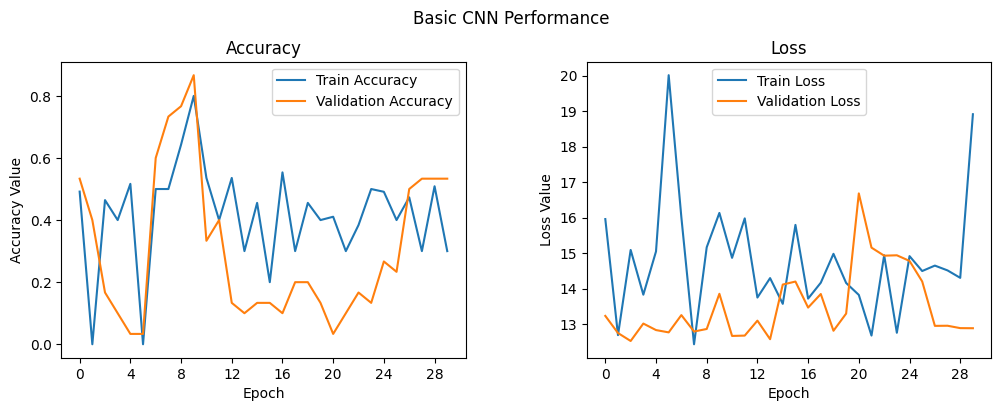

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,30))
ax1.plot(epoch_list, history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 30, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## 5.7 Prediction

In [ ]:
val_generator.classes

pred_labels = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size+1)
pred_labels = np.argmax(pred_labels, axis=1)

target_names = ['Abnormal', 'Normal']
print(classification_report(val_generator.classes, pred_labels, target_names=target_names))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## 5.8 Confusion matrix

[Text(0, 0.5, 'Abnormal'), Text(0, 1.5, 'Normal')]

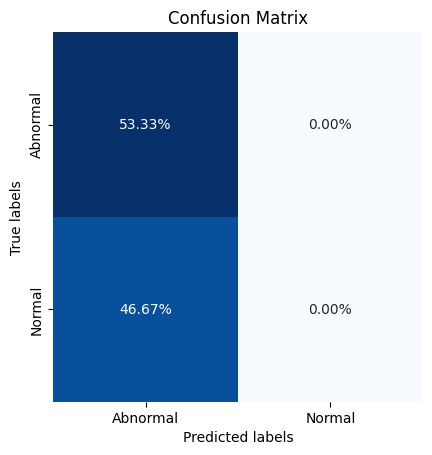

In [ ]:
ax=plt.subplot()
cm=confusion_matrix(val_generator.classes, pred_labels)
sns.heatmap(cm / np.sum(cm), square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.2%')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Abnormal', 'Normal'])
ax.yaxis.set_ticklabels(['Abnormal', 'Normal'])

## 5.9 ROC Curve

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(val_generator.classes, pred_labels, pos_label=1)
metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);